In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import cvxpy as cp
import matplotlib.pyplot as plt
import random
import math
import sys

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
Id = np.eye(2)
X = np.array([[0.0, 1.0],[1.0, 0.0]])
Z = np.array([[1.0, 0.0],[0.0, -1.0]])
Y = np.matmul(X,Z)

zero = np.array([[1.0], [0.0]]) # |0>
one = np.array([[0.0], [1.0]]) # |1>

## Function definitions

In [4]:
def NormalizeState(ipVal):
    if(sp.linalg.norm(ipVal) == 0): return ipVal
    else : return ipVal / sp.linalg.norm(ipVal)
    
def NKron(*args):
  result = np.array([[1.0]])
  for op in args:
    result = np.kron(result, op)
  return result
    
def NKronModified(checkRowMod):
  result = np.array([[1.0]])
  for ind in checkRowMod:
    if(ind == 0):
        op = Id
    elif(ind == 1):
        op = X
    elif(ind == 2):
        op = Y
    elif(ind == 3):
        op = Z
    result = np.kron(result, op)
  return result

def getGenerator(checkRow):
    checkRowModified = np.zeros(n, dtype=int)
    
    checkRowModified[(checkRow[:n] == checkRow[n:]) & (checkRow[n:] == 1)] = 2
    checkRowModified[(checkRow[:n] == 1) & (checkRowModified != 2)] = 1
    checkRowModified[(checkRow[n:] == 1) & (checkRowModified != 2)] = 3
    
    return NKronModified(checkRowModified)  

## Define Generators

In [5]:
checkMatrix = np.array([[0,0,0,1,1,1,1, 0,0,0,0,0,0,0],
                        [0,1,1,0,0,1,1, 0,0,0,0,0,0,0],
                        [1,0,1,0,1,0,1, 0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0, 0,0,0,1,1,1,1],
                        [0,0,0,0,0,0,0, 0,1,1,0,0,1,1],
                        [0,0,0,0,0,0,0, 1,0,1,0,1,0,1]])

# checkMatrix = np.array([[1,0,0,1,0, 0,1,1,0,0],
#                         [0,1,0,0,1, 0,0,1,1,0],
#                         [1,0,1,0,0, 0,0,0,1,1],
#                         [0,1,0,1,0, 1,0,0,0,1]])

n = int(checkMatrix.shape[1]/2)
k = n-checkMatrix.shape[0]

gi = np.zeros([n-k, 2**n, 2**n])
for i in range(n-k):
    gi[i,:,:] = getGenerator(checkMatrix[i,:])

########## G Matrix ##########
Gmatrix = np.eye(gi[0,:,:].shape[0], gi[0,:,:].shape[1]) # generator matrix corresponding to this code
for i in range(n-k):
    Gmatrix = Gmatrix + np.matmul(gi[i,:,:], Gmatrix)
Gmatrix = np.round(Gmatrix)

########## Non-zero unique columns ##########
# get boolean array if the columns are zero or not
zeroCols = np.zeros(Gmatrix.shape[1])
for i in range(Gmatrix.shape[1]):
    zeroCols[i] = all(Gmatrix[:,i] == np.zeros(Gmatrix.shape[0]))

# get indices of non-zero columns
nonZeroColsList = np.argwhere(zeroCols==0).flatten()

# get all non zero columns
GmatrixNonZero = np.zeros([Gmatrix.shape[0], nonZeroColsList.shape[0]])
i = 0
for ind in nonZeroColsList:
    GmatrixNonZero[:,i] = Gmatrix[:,ind]
    i = i+1

# get all non zero and unique columns and there indices
GmatrixNonZeroUniqueInd, nonZeroUniqueInd = np.unique(GmatrixNonZero, axis = 1, return_index=True)
nonZeroUniqueInd = nonZeroColsList[nonZeroUniqueInd]

## Syndrom-Error functions

In [6]:
def getSyndromeFromError(channel_error):
    tx_qbits = np.ones(2**k)
    tx_qbits = NormalizeState(tx_qbits)

    # Convert qbits to tensor product format
    tx_decoded = np.zeros(2**n)
    # get extended qbits corresponding to non-zero column indices of G matrix
    i = 0
    for nonZeroIndex in np.sort(nonZeroUniqueInd):
        if(i>=2**k):
            break
        tx_decoded[nonZeroIndex] = tx_qbits[i]
        i = i+1
    tx_decoded = NormalizeState(tx_decoded)

    # encode transmit qbits
    tx_encoded = NormalizeState(tx_decoded) # encoded transmit qbits
    for i in range(n-k):
        tx_encoded = tx_encoded + np.matmul(gi[i,:,:], tx_encoded) # encode using generators
    tx_encoded = NormalizeState(tx_encoded) # encoded transmit qbits

    # channel
    rx_erry = np.dot(channel_error, tx_encoded) # received qbits with errors

    # syndrome check
    syndr = np.zeros([n-k, 1]) # syndrome
    for i in range(n-k):
        syndr[i] = np.dot(rx_erry.transpose(), np.dot(gi[i,:,:], rx_erry))
        
    return np.ndarray.astype(np.round(syndr), 'int').flatten()

## Parameters

In [7]:
tot_probabs = 10
tot_iter = 100

# train model parameters
tot_samples = 10000

tot_layers=5
hidden_dim=100
hidden_actvn='relu'
output_actvn='sigmoid'
learning_rate = 0.01
tot_epochs = 500

optimizer = Adam(learning_rate)
loss_func='binary_crossentropy' # binary_crossentropy # mean_squared_error
metrics=['binary_crossentropy', 'acc']
verbose_bool = 0

## NN Error Correction

In [8]:
def encode_qbits(qbits):
    # get extended qbits corresponding to non-zero column indices of G matrix
    encoded = np.zeros(2**n)
    i = 0
    for nonZeroIndex in np.sort(nonZeroUniqueInd):
        if(i>=2**k):
            break
        encoded[nonZeroIndex] = qbits[i]
        i = i+1
    encoded = NormalizeState(encoded)

    # encode transmit qbits using generators
    for i in range(n-k):
        encoded = encoded + np.matmul(gi[i,:,:], encoded)
    encoded = NormalizeState(encoded)
    
    return encoded

def depolarizing_channel(input_qbits, p_xyz):
    p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
    errMatrix = np.random.multinomial(1, p_channel, size=n)
    error_vector = errMatrix@np.array([0,1,2,3])
    channel_error = NKronModified(error_vector)
    
    output_qbits = np.dot(channel_error, input_qbits)
    
    error_vector = np.append(error_vector.reshape([n,1]), np.zeros([n,1]), axis=1)
    
    error_vector[error_vector[:,0] == 1, 1] = 1
    error_vector[error_vector[:,0] == 3, 1] = 1
    error_vector[error_vector[:,0] == 1, 0] = 0
    error_vector[error_vector[:,0] == 2, 0] = 1
    error_vector[error_vector[:,0] == 3, 0] = 1
    
    return output_qbits, error_vector.flatten()

def get_syndrome(input_qbits):
    syndr = np.zeros(n-k)
    for i in range(n-k):
        syndr[i] = np.dot(input_qbits.transpose(), np.dot(gi[i,:,:], input_qbits))
    syndr = syndr.flatten() 
    
    syndr[syndr>0] = 0
    syndr[syndr<0] = 1    
    
    return syndr

def generate_data(savefile_bool, p_xyz, tot_samples):

    syndrome_col = np.zeros([tot_samples, n-k])
    error_col = np.zeros([tot_samples, 2*n])

    for i_sample in range(tot_samples):
        # generate qbits randomly
        tx_qbits = np.random.rand(2**k)
        tx_qbits = NormalizeState(tx_qbits)

        # encode qbits
        tx_encoded = encode_qbits(tx_qbits)

        # channel
        rx_erry, error_vector = depolarizing_channel(tx_encoded, p_xyz)

        # syndrome
        syndr = get_syndrome(rx_erry)

        # fill columns
        syndrome_col[i_sample, :] = syndr
        error_col[i_sample, :] = error_vector
        
        if(savefile_bool):
            savefile_name = 'data_' + str(n) + ',' + str(k) + '_tot_samples_'+ str(tot_samples) + '_p_' + str(p_xyz)
            savefile_name_syndr = savefile_name + '_syndr.csv'
            savefile_name_error = savefile_name + '_error.csv'

            np.savetxt(savefile_name_syndr, syndrome_col, delimiter=",")
            np.savetxt(savefile_name_error, error_col, delimiter=",")

            print('Saved files:')
            print(savefile_name_syndr)
            print(savefile_name_error)
        
    return syndrome_col, error_col

def build_decoder(tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics):
    model = Sequential()
    
    model.add(Dense(hidden_dim, activation=hidden_actvn, input_shape=(n-k,), name = 'layer_0'))
    for layers in range(tot_layers-1):
        model.add(Dense(hidden_dim, activation=hidden_actvn, name = 'layer_' + str(layers+1)))
        model.add(BatchNormalization(name='normalize_'+str(layers+1), trainable=True))
    model.add(Dense(2*n, activation=output_actvn, name = 'output_layer'))
    
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)
    
    return model

def train_model(p_xyz, tot_samples, tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics, verbose_bool, tot_epochs):
    syndromes, errors = generate_data(False, p_xyz, tot_samples)
    X_train = syndromes
    y_train = errors

    # process data for argmax P(e/s)

    X_train_unique = np.unique(X_train, axis=0)
    y_train_unique = np.zeros([X_train_unique.shape[0], y_train.shape[1]])

    temp_ind = 0
    for train_sample in X_train_unique:
        temp_error_list = y_train[np.all(X_train == train_sample, axis=1)]  
        temp_error_list_unique, counts = np.unique(temp_error_list, axis=0, return_counts=True)
        y_train_unique[temp_ind] = temp_error_list_unique[counts == max(counts)][0,:].flatten()
        temp_ind = temp_ind + 1

    model = build_decoder(tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics)
    model.fit(X_train_unique, y_train_unique, epochs=500, verbose=verbose_bool)
    
    return model

In [9]:
# syndrome lookup table, but not :P
def get_error_from_syndrome_nn(syndr, model):
    syndr[syndr>0] = 0
    syndr[syndr<0] = 1
    error = model.predict( np.array([syndr]) ).flatten().round().reshape(n,2).T.flatten()
    return error

In [10]:
probab_list = np.linspace(0,0.3333,tot_probabs)
myError_list = np.zeros(tot_probabs)
ber_list_nn = np.zeros(tot_probabs)

ind_probab = 0
avgError = 0

for p_xyz in probab_list:
    
    print('Training model for p = ' + str(p_xyz) + ' (' + str(ind_probab+1) + '/' + str(tot_probabs) + ')')
    model = train_model(p_xyz, tot_samples, tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics, verbose_bool, tot_epochs)

    ber = 0
    myError = 0
    tot_iter_temp = tot_iter
    print('Iterating for p = ' + str(p_xyz))
    for iter_ind in range(tot_iter):
        
        # channel
        p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
        errMatrix = np.random.multinomial(1, p_channel, size=n)
        errCheckRowModified = errMatrix@np.array([0,1,2,3])

        # syndrome check
        syndr = getSyndromeFromError(NKronModified(errCheckRowModified))
    
        # error correction
        recov = get_error_from_syndrome_nn(syndr, model) # error recovery

        errRecov = np.zeros(n)
        errRecov[(recov[:n] == recov[n:]) & (recov[n:] == 1)] = 2
        errRecov[(recov[:n] == 1) & (errRecov != 2)] = 1
        errRecov[(recov[n:] == 1) & (errRecov != 2)] = 3
        
        ber = ber + np.sum(errCheckRowModified != errRecov)
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] Progress = %d%%, " % ('='*int(np.round(((iter_ind+1)/tot_iter)*39))+'>', ((iter_ind+1)/tot_iter)*100) + ' BER = ' + str(ber/(iter_ind*n+n)))
        sys.stdout.flush()
    
    ber = ber/(tot_iter*n)
    myError = myError/tot_iter_temp
    avgError = myError
    
    myError_list[ind_probab] = myError
    ber_list_nn[ind_probab] = ber
    
    ind_probab = ind_probab + 1
    print(' ')

Training model for p = 0.0 (1/10)
Iterating for p = 0.0
[=======================================>] Progress = 100%,  BER = 0.0 
Training model for p = 0.037033333333333335 (2/10)
Iterating for p = 0.037033333333333335
[=======================================>] Progress = 100%,  BER = 0.11714285714285715 
Training model for p = 0.07406666666666667 (3/10)
Iterating for p = 0.07406666666666667
[=======================================>] Progress = 100%,  BER = 0.27714285714285714 
Training model for p = 0.1111 (4/10)
Iterating for p = 0.1111
[=======================================>] Progress = 100%,  BER = 0.4042857142857143 
Training model for p = 0.14813333333333334 (5/10)
Iterating for p = 0.14813333333333334
[=======================================>] Progress = 100%,  BER = 0.5185714285714286 
Training model for p = 0.18516666666666667 (6/10)
Iterating for p = 0.18516666666666667
[=======================================>] Progress = 100%,  BER = 0.6328571428571429 
Training model for 

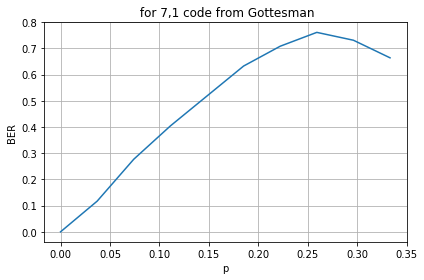

In [11]:
plt.plot(probab_list, ber_list_nn)
plt.ylabel('BER')
plt.xlabel('p')
plt.title(' for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()

# saveName = './plots/' + errSaveName + '_' + str(n) + ',' + str(k) + '_iter_' + str(tot_iter) + '_totp_' + str(tot_probabs) + '.png'
plt.show()
# plt.savefig(saveName)
# print(saveName)

## MAP Lookup

In [12]:
probab_list = np.linspace(0,0.3333,tot_probabs)
myError_list = np.zeros(tot_probabs)
ber_list_map = np.zeros(tot_probabs)

ind_probab = 0
avgError = 0

for p_xyz in probab_list:
    
    print('Getting MAP for p = ' + str(p_xyz) + ' (' + str(ind_probab+1) + '/' + str(tot_probabs) + ')')
    
    syndromes, errors = generate_data(False, p_xyz, tot_samples)
    X_train = syndromes
    y_train = errors

    # process data for argmax P(e/s)

    X_train_unique = np.unique(X_train, axis=0)
    y_train_unique = np.zeros([X_train_unique.shape[0], y_train.shape[1]])

    temp_ind = 0
    for train_sample in X_train_unique:
        temp_error_list = y_train[np.all(X_train == train_sample, axis=1)]  
        temp_error_list_unique, counts = np.unique(temp_error_list, axis=0, return_counts=True)
        y_train_unique[temp_ind] = temp_error_list_unique[counts == max(counts)][0,:].flatten()
        temp_ind = temp_ind + 1
    
    ber = 0
    myError = 0
    tot_iter_temp = tot_iter
    print('Iterating for p = ' + str(p_xyz))
    for iter_ind in range(tot_iter):
        
        # channel
        p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
        errMatrix = np.random.multinomial(1, p_channel, size=n)
        errCheckRowModified = errMatrix@np.array([0,1,2,3])

        # syndrome check
        syndr = getSyndromeFromError(NKronModified(errCheckRowModified))
        syndr[syndr>0] = 0
        syndr[syndr<0] = 1
        # error correction
        recov = y_train_unique[np.all(X_train_unique == syndr, axis=1),:].flatten()

        errRecov = np.zeros(n)
        errRecov[(recov[:n] == recov[n:]) & (recov[n:] == 1)] = 2
        errRecov[(recov[:n] == 1) & (errRecov != 2)] = 1
        errRecov[(recov[n:] == 1) & (errRecov != 2)] = 3
        
        ber = ber + np.sum(errCheckRowModified != errRecov)
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] Progress = %d%%, " % ('='*int(np.round(((iter_ind+1)/tot_iter)*39))+'>', ((iter_ind+1)/tot_iter)*100) + ' BER = ' + str(ber/(iter_ind*n+n)))
        sys.stdout.flush()
    
    ber = ber/(tot_iter*n)
    myError = myError/tot_iter_temp
    avgError = myError
    
    myError_list[ind_probab] = myError
    ber_list_map[ind_probab] = ber
    
    ind_probab = ind_probab + 1
    print(' ')

Getting MAP for p = 0.0 (1/10)
Iterating for p = 0.0
[=======================================>] Progress = 100%,  BER = 0.0 
Getting MAP for p = 0.037033333333333335 (2/10)
Iterating for p = 0.037033333333333335
[=======================================>] Progress = 100%,  BER = 0.1991919191919194 
Getting MAP for p = 0.07406666666666667 (3/10)
Iterating for p = 0.07406666666666667
[=======================================>] Progress = 100%,  BER = 0.36142857142857143 
Getting MAP for p = 0.1111 (4/10)
Iterating for p = 0.1111
[=======================================>] Progress = 100%,  BER = 0.4411544011544013 
Getting MAP for p = 0.14813333333333334 (5/10)
Iterating for p = 0.14813333333333334
[=======================================>] Progress = 100%,  BER = 0.5614285714285714 
Getting MAP for p = 0.18516666666666667 (6/10)
Iterating for p = 0.18516666666666667
[=======================================>] Progress = 100%,  BER = 0.6014285714285714 
Getting MAP for p = 0.2222 (7/10)
Iter

## Look-up Table Error Correction

In [13]:
comparingAccuracy_syndrome = 1e-5
def fillSyndromeTable(checkRowCorrect):
    # get error corresponding to the given vector
    err = getGenerator(checkRowCorrect)

    # get syndrome of that error
    syndrVal = np.zeros(n-k,dtype='int')
    for i in range(n-k):
        syndBool = np.all(     np.abs(np.matmul(np.matmul(err, gi[i,:,:]), err.transpose()) - gi[i,:,:]) < comparingAccuracy_syndrome    )
        if syndBool == True:
            syndrVal[i] = 1
        else:
            syndrVal[i] = -1

    # convert syndrome to index
    syndrIndex = int(''.join(['1' if x else '0' for x in syndrVal==1]), 2)

    # if not already updated, update the syndrome table
    if isFilledTable[syndrIndex] == 0:
        errorRecoveryList[syndrIndex, :] = checkRowCorrect
        isFilledTable[syndrIndex] = 1 
        
#### Weight 1 errors:

isFilledTable = np.zeros(2**(n-k))
errorRecoveryList = np.zeros([2**(n-k), 2*n])
string_format = '{:0>' + str(n) + '}'
totErrChecked = 0

fillSyndromeTable(np.zeros(2*n, dtype = 'int'))
totErrChecked = totErrChecked + 1

myIndex = 1
while(myIndex < 2**(n)):
    # generate weight 1 vectors
    checkRow = list(string_format.format("{:b}".format(myIndex)))
    checkRow = list(map(int, checkRow))
    
    # weight 1 error with X, then Y and then Z 
    fillSyndromeTable(np.append(np.asarray(checkRow), np.zeros(n, dtype = 'int')))
    fillSyndromeTable(np.append(np.zeros(n, dtype = 'int'), np.asarray(checkRow)))
    fillSyndromeTable(np.append(np.asarray(checkRow), np.asarray(checkRow)))
    
    totErrChecked = totErrChecked + 3
        
    myIndex = myIndex*2   
    
#### Weight 2 errors:

myIndex1 = 1
while(myIndex1 < 2**(n)):
    # generate weight 1 vectors
    checkRow1 = list(string_format.format("{:b}".format(myIndex1)))
    checkRow1 = np.asarray(list(map(int, checkRow1)))
    
    myIndex2 = myIndex1*2
    while(myIndex2 < 2**n):
        # generate another weight 1 vector
        checkRow2 = list(string_format.format("{:b}".format(myIndex2)))
        checkRow2 = np.asarray(list(map(int, checkRow2)))
        
        #generate weight 2 vector
        checkRow3 = list(string_format.format("{:b}".format(myIndex2)))
        checkRow3 = np.asarray(list(map(int, checkRow3)))
        checkRow3[checkRow1 == 1] = 1
        
        # add weight 2 errors with XX, XY, XZ, ...
        fillSyndromeTable(np.append(checkRow3, np.zeros(n, dtype = 'int')))
        fillSyndromeTable(np.append(checkRow3, checkRow1))
        fillSyndromeTable(np.append(checkRow2, checkRow1))
        
        fillSyndromeTable(np.append(checkRow3, checkRow2))
        fillSyndromeTable(np.append(checkRow3, checkRow3))
        fillSyndromeTable(np.append(checkRow2, checkRow3))
        
        fillSyndromeTable(np.append(checkRow1, checkRow2))
        fillSyndromeTable(np.append(checkRow1, checkRow3))      
        fillSyndromeTable(np.append(np.zeros(n, dtype = 'int'), checkRow3))
        
        totErrChecked = totErrChecked + 9
        myIndex2 = myIndex2*2
        
    myIndex1 = myIndex1*2   
    
#### Weight 3 errors:

myIndex1 = 1
tempcount = 0
tempc = 0
while(myIndex1 < 2**(n)):
    # generate weight 1 vectors
    checkRowList = np.zeros([n, 4])
    
    checkRow1 = list(string_format.format("{:b}".format(myIndex1)))
    checkRow1 = np.asarray(list(map(int, checkRow1)))
    
    checkRowCombined1 = list(string_format.format("{:b}".format(myIndex1)))
    checkRowCombined1 = np.asarray(list(map(int, checkRowCombined1)))
    
    myIndex2 = myIndex1*2
    while(myIndex2 < 2**n):
        # generate another weight 1 vector
        checkRow2 = list(string_format.format("{:b}".format(myIndex2)))
        checkRow2 = np.asarray(list(map(int, checkRow2)))
        
        checkRowCombined2 = list(string_format.format("{:b}".format(myIndex2)))
        checkRowCombined2 = np.asarray(list(map(int, checkRowCombined2)))
        
        myIndex3 = myIndex2*2
        while(myIndex3 < 2**n):
            # generate another weight 1 vector
            checkRow3 = list(string_format.format("{:b}".format(myIndex3)))
            checkRow3 = np.asarray(list(map(int, checkRow3)))
            
            # generate weight 2 and 3 vectors
            checkRowCombined3 = list(string_format.format("{:b}".format(myIndex3)))
            checkRowCombined3 = np.asarray(list(map(int, checkRowCombined3)))
            
            checkRowCombined4 = list(string_format.format("{:b}".format(myIndex3)))
            checkRowCombined4 = np.asarray(list(map(int, checkRowCombined4)))
            
            checkRowCombined1[checkRow2 == 1] = 1
            checkRowCombined2[checkRow3 == 1] = 1
            checkRowCombined3[checkRow1 == 1] = 1
            
            checkRowCombined4[checkRow2 == 1] = 1
            checkRowCombined4[checkRow1 == 1] = 1
            
            fillSyndromeTable(np.append(checkRowCombined4, np.zeros(n, dtype = 'int')))
            fillSyndromeTable(np.append(checkRowCombined4, checkRow1))
            fillSyndromeTable(np.append(checkRowCombined4, checkRow2))
            fillSyndromeTable(np.append(checkRowCombined4, checkRow3))
            fillSyndromeTable(np.append(checkRowCombined4, checkRowCombined1))
            fillSyndromeTable(np.append(checkRowCombined4, checkRowCombined2))
            fillSyndromeTable(np.append(checkRowCombined4, checkRowCombined3))
            fillSyndromeTable(np.append(checkRowCombined4, checkRowCombined4))
            fillSyndromeTable(np.append(checkRowCombined3, checkRowCombined4))
            fillSyndromeTable(np.append(checkRowCombined2, checkRowCombined4))
            fillSyndromeTable(np.append(checkRowCombined1, checkRowCombined4))
            fillSyndromeTable(np.append(checkRow3, checkRowCombined4))
            fillSyndromeTable(np.append(checkRow2, checkRowCombined4))
            fillSyndromeTable(np.append(checkRow1, checkRowCombined4))
            fillSyndromeTable(np.append(np.zeros(n, dtype = 'int'), checkRowCombined4))
            
            fillSyndromeTable(np.append(checkRowCombined3, checkRowCombined2))
            fillSyndromeTable(np.append(checkRowCombined3, checkRowCombined1))
            fillSyndromeTable(np.append(checkRowCombined3, checkRow2))
            fillSyndromeTable(np.append(checkRowCombined2, checkRowCombined3))
            fillSyndromeTable(np.append(checkRowCombined1, checkRowCombined3))
            fillSyndromeTable(np.append(checkRow2, checkRowCombined3))
            
            fillSyndromeTable(np.append(checkRowCombined2, checkRowCombined1))
            fillSyndromeTable(np.append(checkRowCombined2, checkRow1))
            fillSyndromeTable(np.append(checkRowCombined1, checkRowCombined2))
            fillSyndromeTable(np.append(checkRow1, checkRowCombined2))
            
            fillSyndromeTable(np.append(checkRowCombined1, checkRow3))
            fillSyndromeTable(np.append(checkRow3, checkRowCombined1))

            totErrChecked = totErrChecked + 27
            if(np.sum(isFilledTable == 1) == isFilledTable.shape[0]):
                break
            myIndex3 = myIndex3*2
        
        if(np.sum(isFilledTable == 1) == isFilledTable.shape[0]):
            break
        myIndex2 = myIndex2*2
    
    if(np.sum(isFilledTable == 1) == isFilledTable.shape[0]):
        break
    myIndex1 = myIndex1*2 

In [14]:
# syndrome lookup table
def get_error_from_syndrome_lookup(syndr):
    errorSyndromeIndex = int(''.join(['1' if x else '0' for x in np.ndarray.astype( np.round(syndr.flatten()), int) == 1]), 2)
    recov = errorRecoveryList[errorSyndromeIndex]
    return recov

In [15]:
probab_list = np.linspace(0,0.3333,tot_probabs)
myError_list = np.zeros(tot_probabs)
ber_list_lookup = np.zeros(tot_probabs)

ind_probab = 0
avgError = 0

for p_xyz in probab_list:
    ber = 0
    print('Iterating for p = ' + str(p_xyz) + ' (' + str(ind_probab+1) + '/' + str(tot_probabs) + ')')
    
    myError = 0
    tot_iter_temp = tot_iter
    for iter_ind in range(tot_iter):
        
        # channel
        p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
        errMatrix = np.random.multinomial(1, p_channel, size=n)
        errCheckRowModified = errMatrix@np.array([0,1,2,3])

        # syndrome check
        syndr = getSyndromeFromError(NKronModified(errCheckRowModified))
    
        # error correction
        recov = get_error_from_syndrome_lookup(syndr) # error recovery

        errRecov = np.zeros(n)
        errRecov[(recov[:n] == recov[n:]) & (recov[n:] == 1)] = 2
        errRecov[(recov[:n] == 1) & (errRecov != 2)] = 1
        errRecov[(recov[n:] == 1) & (errRecov != 2)] = 3
        
        ber = ber + np.sum(errCheckRowModified != errRecov)
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] Progress = %d%%, " % ('='*int(np.round(((iter_ind+1)/tot_iter)*39))+'>', ((iter_ind+1)/tot_iter)*100) + ' BER = ' + str(ber/(iter_ind*n+n)))
        sys.stdout.flush()
    
    ber = ber/(tot_iter*n)
    myError = myError/tot_iter_temp
    avgError = myError
    
    myError_list[ind_probab] = myError
    ber_list_lookup[ind_probab] = ber
    
    ind_probab = ind_probab + 1
    print(' ')

Iterating for p = 0.0 (1/10)
[=======================================>] Progress = 100%,  BER = 0.0 
Iterating for p = 0.037033333333333335 (2/10)
[=======================================>] Progress = 100%,  BER = 0.055714285714285716 
Iterating for p = 0.07406666666666667 (3/10)
[=======================================>] Progress = 100%,  BER = 0.18857142857142858 
Iterating for p = 0.1111 (4/10)
[=======================================>] Progress = 100%,  BER = 0.3442857142857143 
Iterating for p = 0.14813333333333334 (5/10)
[=======================================>] Progress = 100%,  BER = 0.5182251082251085 
Iterating for p = 0.18516666666666667 (6/10)
[=======================================>] Progress = 100%,  BER = 0.5985714285714285 
Iterating for p = 0.2222 (7/10)
[=======================================>] Progress = 100%,  BER = 0.697546897546898 
Iterating for p = 0.2592333333333333 (8/10)
[=======================================>] Progress = 100%,  BER = 0.7728571428571429 

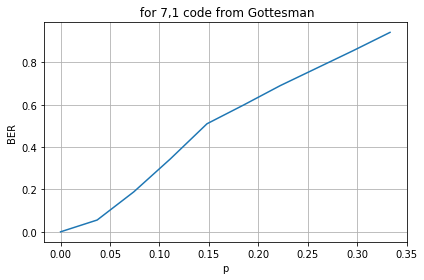

In [16]:
plt.plot(probab_list, ber_list_lookup)
plt.ylabel('BER')
plt.xlabel('p')
plt.title(' for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()

# saveName = './plots/' + errSaveName + '_' + str(n) + ',' + str(k) + '_iter_' + str(tot_iter) + '_totp_' + str(tot_probabs) + '.png'
plt.show()
# plt.savefig(saveName)
# print(saveName)

## Algorithmic Error Correction

In [17]:
def getCardin(myVector):
    return np.sum(myVector != 0)

def get_error_from_syndrome_algo(syndr):
    syndr[syndr>0] = 0
    syndr[syndr<0] = 1
    success = 0
    finalError = np.zeros(2*errCheckRowModified.shape[0])
    while(getCardin(syndr) != 0):
        maxMetric = 0
        for generatorInd in range(n-k): # for all generators
            g = checkMatrix[generatorInd, :] # get the genrator
            g_modified = np.zeros(n, dtype=int)
            g_modified[(g[:n] == g[n:]) & (g[n:] == 1)] = 2
            g_modified[(g[:n] == 1) & (g_modified != 2)] = 1
            g_modified[(g[n:] == 1) & (g_modified != 2)] = 3
            
            string_format = '{:0>' + str(2*getCardin(g_modified)) + '}'
            for errorIndex in range(2**(2*getCardin(g_modified))): # for all errors with the support of that generator
                if(errorIndex == 0): continue
                thisError = np.copy(g_modified)
                
                modifyError = list(string_format.format("{:b}".format(errorIndex)))
                modifyError =  np.asarray(list(map(int, modifyError)) )
                
                temp_n = getCardin(g_modified)
                modifyErrorModified = np.zeros(temp_n, dtype=int)
                modifyErrorModified[(modifyError[:temp_n] == modifyError[temp_n:]) & (modifyError[temp_n:] == 1)] = 2
                modifyErrorModified[(modifyError[:temp_n] == 1) & (modifyErrorModified != 2)] = 1
                modifyErrorModified[(modifyError[temp_n:] == 1) & (modifyErrorModified != 2)] = 3
                
                thisError[thisError != 0] = modifyErrorModified # get the error
                
                           
                thisError1 = np.copy(thisError)
                thisError1[thisError == 1] = 1
                thisError1[thisError == 2] = 1
                thisError1[thisError == 3] = 0
                
                thisError2 = np.copy(thisError)
                thisError2[thisError == 1] = 0
                thisError2[thisError == 2] = 1
                thisError2[thisError == 3] = 1
                
                thisError = np.append(thisError1, thisError2)
                
#                 print('Im here ' + str(syndr))
                syndr_new = (syndr + getSyndromeFromError(getGenerator(thisError)))%2 # update to syndrome to check weight
                thisMetric = (getCardin(syndr) - getCardin(syndr_new))/getCardin(modifyErrorModified) # get the metric
                
                if(thisMetric > maxMetric):
                    bestError = thisError
                    maxMetric = thisMetric
#                 if(thisMetric == maxMetric):
#                     print('Error = ' + str(thisError) + ', |s_i+1| = ' + str(getCardin(syndr_new)) + ', |s_i| = ' + str(getCardin(syndr)) + ', |e| = ' + str(getCardin(thisError)))

        if(maxMetric != 0):
            finalError = bestError
            syndr = (syndr + getSyndromeFromError(getGenerator(bestError)))%2
        if(maxMetric == 0):
            break        
#         print('Max metric = ' + str(maxMetric) + ', Best error = ' + str(bestError) + ', Syndrome = ' + str(syndr))

    if(getCardin(syndr) != 0): success = 0
    else: success = 1

    return finalError.flatten(), success

In [18]:
probab_list = np.linspace(0,0.3333,tot_probabs)
myError_list = np.zeros(tot_probabs)
ber_list_algo = np.zeros(tot_probabs)

ind_probab = 0
avgError = 0

tot_iter = 10

for p_xyz in probab_list:
    ber = 0
    print('Iterating for p = ' + str(p_xyz) + ' (' + str(ind_probab+1) + '/' + str(tot_probabs) + ')')
    
    myError = 0
    tot_iter_temp = tot_iter
    for iter_ind in range(tot_iter):
        
        # channel
        p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
        errMatrix = np.random.multinomial(1, p_channel, size=n)
        errCheckRowModified = errMatrix@np.array([0,1,2,3])

        # syndrome check        
        syndr = getSyndromeFromError(NKronModified(errCheckRowModified))

        # error correction
        recov, success = get_error_from_syndrome_algo(syndr) # error recovery

        errRecov = np.zeros(n)
        errRecov[(recov[:n] == recov[n:]) & (recov[n:] == 1)] = 2
        errRecov[(recov[:n] == 1) & (errRecov != 2)] = 1
        errRecov[(recov[n:] == 1) & (errRecov != 2)] = 3
        
        ber = ber + np.sum(errCheckRowModified != errRecov)
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] Progress = %d%%, " % ('='*int(np.round(((iter_ind+1)/tot_iter)*39))+'>', ((iter_ind+1)/tot_iter)*100) + ' BER = ' + str(ber/(iter_ind*n+n)))
        sys.stdout.flush()
    
    ber = ber/(tot_iter*n)
    myError = myError/tot_iter_temp
    avgError = myError
    
    myError_list[ind_probab] = myError
    ber_list_algo[ind_probab] = ber
    
    ind_probab = ind_probab + 1
    print(' ')

Iterating for p = 0.0 (1/10)
[=======================================>] Progress = 100%,  BER = 0.0 
Iterating for p = 0.037033333333333335 (2/10)
[=======================================>] Progress = 100%,  BER = 0.18571428571428572 
Iterating for p = 0.07406666666666667 (3/10)
[=======================================>] Progress = 100%,  BER = 0.44285714285714284 
Iterating for p = 0.1111 (4/10)
[=======================================>] Progress = 100%,  BER = 0.4714285714285714 
Iterating for p = 0.14813333333333334 (5/10)
[=======================================>] Progress = 100%,  BER = 0.42857142857142855 
Iterating for p = 0.18516666666666667 (6/10)
[=======================================>] Progress = 100%,  BER = 0.5285714285714286 
Iterating for p = 0.2222 (7/10)
[=======================================>] Progress = 100%,  BER = 0.6142857142857143 
Iterating for p = 0.2592333333333333 (8/10)
[=======================================>] Progress = 100%,  BER = 0.8714285714285714

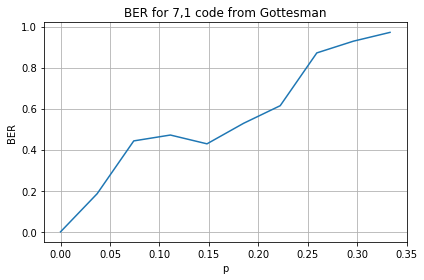

In [19]:
plt.plot(probab_list, ber_list_algo)
plt.ylabel('BER')
plt.xlabel('p')
plt.title('BER for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()

plt.show()

# saveName = './plots/1' + errSaveName + '_' + str(n) + ',' + str(k) + '_iter_' + str(tot_iter) + '_totp_' + str(tot_probabs) + '.png'
# plt.savefig(saveName)
# print(saveName)

## Combined Plots

In [20]:
# ber_list_algo = np.array([0.    , 0.125 , 0.2538, 0.3684, 0.4672, 0.5698, 0.678 , 0.7904, 0.873 , 0.9778])
# ber_list_lookup = np.array([0.    , 0.0696, 0.1916, 0.3496, 0.4688, 0.5866, 0.686 , 0.7728, 0.8594, 0.965 ])

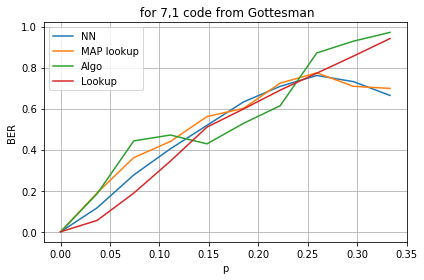

In [23]:
plt.plot(probab_list, ber_list_nn)
plt.plot(probab_list, ber_list_map)
plt.plot(probab_list, ber_list_algo)
plt.plot(probab_list, ber_list_lookup)

plt.ylabel('BER')
plt.xlabel('p')
plt.title(' for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()
plt.legend(['NN', 'MAP lookup', 'Algo', 'Lookup'])

# plt.savefig('combined_plot_7,1', dpi=300)